## Load Dataset

A short script to load the data and preprocess it into a dataset

In [1]:
import numpy as np
import os
import cv2
from sklearn.utils import shuffle

In [2]:
def load_data(dir, c):
    images = []
    label = []
    for filename in os.listdir(dir):
        if filename.endswith(".jpg"): 
            im = cv2.imread(os.path.join(dir, filename)).astype(np.float32)
            images.append(im/255)
            label.append(c)
    return np.array(images), np.array(label)

In [3]:
def load_data_set(dir):
    try:
        train_x, train_y, test_x, test_y = np.load("dataset.npy")
    except:
        categories = ["r0", "r1", "r2", "r3"]
        images = []
        label = []
        for i, c in enumerate(categories):
            x, y = load_data(os.path.join(dir, c), i)
            images.append(x)
            label.append(y)
        data_x = np.concatenate(images, axis = 0)
        data_y = np.concatenate(label)
        data_x, data_y = shuffle(data_x, data_y, random_state=0)

        size = len(data_x)
        sep = int(size*0.9)

        train_x = data_x[:sep]
        train_y = data_y[:sep]
        test_x = data_x[sep:]
        test_y = data_y[sep:]
        np.save("dataset",[train_x, train_y, test_x, test_y])
    return train_x, train_y, test_x, test_y
    

## Data Visualization

Let us visualize the data to gain a better understanding of it

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_x, train_y, test_x, test_y = load_data_set('4 categories')

In [6]:
def visualize(x, y):
    imgplot = plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.title("Category:" + str(y))
    plt.show()

In [7]:
def visualize_dataset(train_x, train_y):
    categories = [0, 1, 2, 3]
    for c in categories:
        for i in xrange(len(train_y)):
            if train_y[i] == c:
                visualize(train_x[i], train_y[i])
                break

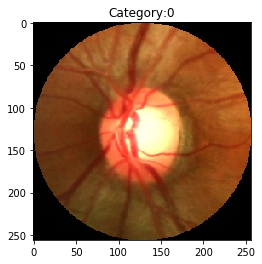

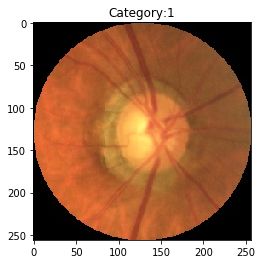

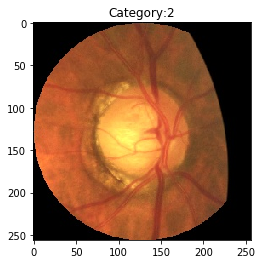

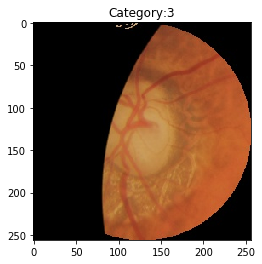

In [8]:
visualize_dataset(train_x, train_y)

As seen in the images above, by comparing the different categories side by side, corneal image in the category with higher number seems to be cloudier than the others.

## Baseline Model

To measure the difficulty of the dataset for classification, I will use a 2 layer convolutional neural net to see how well a naive approach will perform on this dataset

In [9]:
import tensorflow as tf

/home/tingchel/miniconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
tf.__version__

'1.5.0'

In [11]:
# Variables

img_size = 256
num_classes = 3
n_channels = 3
data_set_size = 1746
batch_size = 64
display_step = 200
num_steps = 2000

In [13]:
def inference(images, training):
    
    input_layer = images
    
    with tf.variable_scope('conv1_1') as scope:
        conv1_1 = tf.layers.conv2d(inputs = input_layer,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm1_1 = tf.layers.batch_normalization(inputs = conv1_1)
        conv1_1 = tf.nn.relu(norm1_1, name=scope.name)
    
#     pool1 = tf.layers.max_pooling2d(inputs = conv1,
#                                    pool_size = [3,3],
#                                    strides = [2,2],
#                                    name = 'pool1')
    
    with tf.variable_scope('conv1_2') as scope:
        conv1_2 = tf.layers.conv2d(inputs = conv1_1,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm1_2 = tf.layers.batch_normalization(inputs = conv1_2)
        conv1_2 = tf.nn.relu(norm1_2, name=scope.name)
    
    
    pool1 = tf.layers.max_pooling2d(inputs = conv1_2,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool1')
    with tf.variable_scope('conv2_1') as scope:
        conv2_1 = tf.layers.conv2d(inputs = pool1,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm2_1 = tf.layers.batch_normalization(inputs = conv2_1)
        conv2_1 = tf.nn.relu(norm2_1, name=scope.name)
        
    with tf.variable_scope('conv2_2') as scope:
        conv2_2 = tf.layers.conv2d(inputs = conv2_1,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm2_2 = tf.layers.batch_normalization(inputs = conv2_2)
        conv2_2 = tf.nn.relu(norm2_2, name=scope.name)
    
    
    pool2 = tf.layers.max_pooling2d(inputs = conv2_2,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool2')
    with tf.variable_scope('conv3_1') as scope:
        conv3_1 = tf.layers.conv2d(inputs = pool2,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm3_1 = tf.layers.batch_normalization(inputs = conv3_1)
        conv3_1 = tf.nn.relu(norm3_1, name=scope.name)
        
    with tf.variable_scope('conv3_2') as scope:
        conv3_2 = tf.layers.conv2d(inputs = conv2_1,
                                filters = 32,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm3_2 = tf.layers.batch_normalization(inputs = conv3_2)
        conv3_2 = tf.nn.relu(norm3_2, name=scope.name)
    
    pool3 = tf.layers.max_pooling2d(inputs = conv3_2,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool3')
    
    with tf.variable_scope('local3') as scope:
        pool2_flat = tf.layers.flatten(pool3)
        dense3 = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
        dropout3 = tf.layers.dropout(
              inputs=dense3, rate=0.6, training=training, name=scope.name)
    
    with tf.variable_scope('local4') as scope:
        dense4 = tf.layers.dense(inputs=dropout3, units=128, activation=tf.nn.relu)
        dropout4 = tf.layers.dropout(
              inputs=dense4, rate=0.6, training=training, name=scope.name)
    
    logits = tf.layers.dense(inputs=dropout4, units=4, name="logits")
    
    return logits
    

In [14]:
def loss_fn(logits, labels):
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    return loss

In [15]:
def input_pipeline(train_x, train_y, batch_size, step):
    
    start = (step-1)*batch_size % len(train_x)
    end = (step)*batch_size % len(train_x)
    
    if end < start:
        start = end
        end = (step+1)*batch_size % len(train_x)
        train_x, train_y = shuffle(train_x, train_y, random_state=0)
    
    batch_x, batch_y = train_x[start:end], train_y[start:end]

    return batch_x, batch_y

In [16]:
def train():

    train_x, train_y, test_x, test_y = load_data_set('4 categories')
    
    Images = tf.placeholder(tf.float32, shape = [None, img_size, img_size, n_channels])
    Labels = tf.placeholder(tf.int64, shape = [None,])
    training = tf.placeholder(tf.bool)
    
    logits = inference(Images, training)
    loss_op = loss_fn(logits, Labels)
    
    correct_pred = tf.equal(tf.argmax(logits, 1), Labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    train_op = tf.train.AdamOptimizer(1e-4).minimize(loss_op)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        
        for step in range(1, num_steps+1):

            batch_x, batch_y = input_pipeline(train_x, train_y, batch_size, step)

            sess.run(train_op, feed_dict={Images:batch_x, Labels:batch_y, training: True})
            if step % display_step == 0 or step == 1:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={Images: batch_x,
                                                                     Labels: batch_y,
                                                                 training: False})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

#                 test_image, test_label = sess.run([eval_tensor_x, eval_tensor_y])
                print("Testing Accuracy:", \
                    sess.run(accuracy, feed_dict={Images: test_x,
                                                  Labels: test_y,
                                                 training: False}))
        print("Optimization Finished!")
#         test_image, test_label = sess.run([eval_tensor_x, eval_tensor_y])
        print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={Images: test_x,
                                      Labels: test_y,
                                     training: False}))

    

In [15]:
train()

Step 1, Minibatch Loss= 1.3608, Training Accuracy= 0.297
('Testing Accuracy:', 0.2783505)
Step 200, Minibatch Loss= 0.7498, Training Accuracy= 0.656
('Testing Accuracy:', 0.61340207)
Step 400, Minibatch Loss= 0.6249, Training Accuracy= 0.719
('Testing Accuracy:', 0.66494846)
Step 600, Minibatch Loss= 0.5253, Training Accuracy= 0.812
('Testing Accuracy:', 0.6443299)
Step 800, Minibatch Loss= 0.4117, Training Accuracy= 0.844
('Testing Accuracy:', 0.6443299)
Step 1000, Minibatch Loss= 0.3513, Training Accuracy= 0.812
('Testing Accuracy:', 0.6494845)
Step 1200, Minibatch Loss= 0.3024, Training Accuracy= 0.828
('Testing Accuracy:', 0.6494845)
Step 1400, Minibatch Loss= 0.1690, Training Accuracy= 0.969
('Testing Accuracy:', 0.685567)
Step 1600, Minibatch Loss= 0.2538, Training Accuracy= 0.891
('Testing Accuracy:', 0.6494845)
Step 1800, Minibatch Loss= 0.1928, Training Accuracy= 0.938
('Testing Accuracy:', 0.63917524)
Step 2000, Minibatch Loss= 0.0774, Training Accuracy= 0.984
('Testing Accur

KeyboardInterrupt: 

## Data Augmentation

As seen from the results above, the neural network easily overfited to the dataset. This meant that the dataset is too small to make accurate predictions. We will use data augmentation techniques here to increase the data size from 1746 to 12000. We will randomly rotate, add noise and flip the image.

In [17]:
def add_gaussian_noise(X_imgs, Y_labels):
    gaussian_noise_imgs = []
    labels = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    for i in xrange(len(X_imgs)):
        ratio = 0.25 * np.random.random() + 0.75 #between 1 and 0.75
        X_img = X_imgs[i]            
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, ratio, (1-ratio) * gaussian, (1-ratio), 0)
        gaussian_noise_imgs.append(gaussian_img)
        labels.append(Y_labels[i])
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    labels = np.array(labels, dtype = np.int64)
    return gaussian_noise_imgs, labels

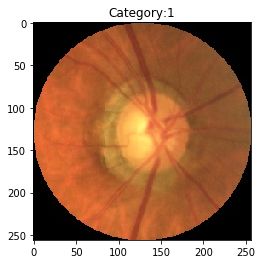

(1, 256, 256, 3)


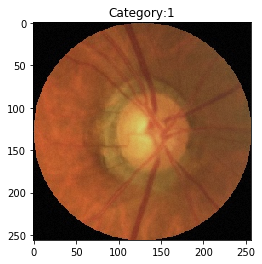

In [18]:
visualize(train_x[0], 1)
print train_x[:1].shape

x, y = add_gaussian_noise(train_x[:1], train_y[:1])

visualize(x[0],y[0])

In [19]:
def flip_images(X_imgs, Y_labels):
    X_flip = []
    labels = []
    for i in xrange(len(X_imgs)):
        img = X_imgs[i]
        X_flip.append(np.flip(img,1))
        labels.append(Y_labels[i])
        X_flip.append(np.flip(img,0))
        labels.append(Y_labels[i])
        X_flip.append(np.transpose(img, (1, 0, 2)))
        labels.append(Y_labels[i])
    X_flip = np.array(X_flip, dtype = np.float32)
    labels = np.array(labels, dtype = np.int64)
    return X_flip, labels

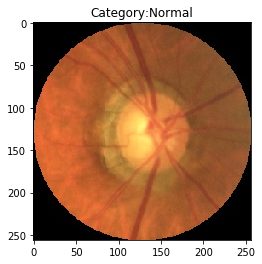

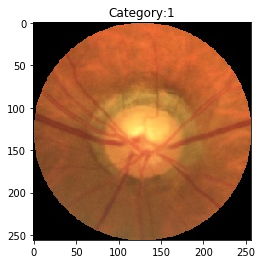

In [20]:
visualize(train_x[0], "Normal")

x, y = flip_images(train_x[:1], train_y[:1])

visualize(x[2],y[2])

In [21]:
from math import pi
import scipy.ndimage

def rotate_images(X_imgs, Y_labels, start_angle, end_angle, n_images):
    X_rotate = []
    labels = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    for i in xrange(n_images):
        degrees_angle = start_angle + i * iterate_at
        for i in xrange(len(X_imgs)):
            img = X_imgs[i]
            rotated_img = scipy.ndimage.rotate(img, degrees_angle,reshape=False, order=1)
            X_rotate.append(rotated_img)
            labels.append(Y_labels[i])
    X_rotate = np.array(X_rotate, dtype = np.float32)
    labels = np.array(labels, dtype = np.int64)
    return X_rotate, labels

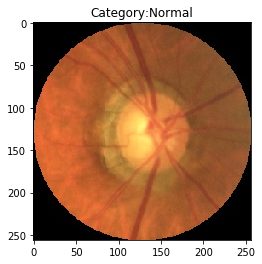

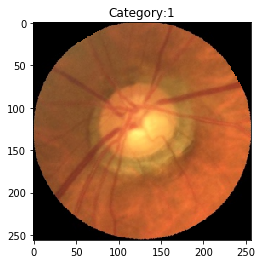

In [22]:
visualize(train_x[0], "Normal")
x, y = rotate_images(train_x[:1], train_y[:1], 0, 360, 10)

visualize(x[3],y[3])

In [23]:
def data_augmentation(train_x, train_y, test_x, test_y):

    flipped_imgs, flipped_lab = flip_images(train_x,train_y)
    rotated_imgs, rotated_lab = rotate_images(train_x,train_y, 0, 360, 5)
    augmented_img = np.concatenate((train_x, flipped_imgs, rotated_imgs))
    augmented_lab = np.concatenate((train_y, flipped_lab, rotated_lab))
    rand = np.random.randint(len(augmented_img), size=int(len(augmented_img)*0.2))
    gauss_imgs, gauss_lab = add_gaussian_noise(augmented_img[rand], augmented_lab[rand])
    augmented_img = np.concatenate((augmented_img, gauss_imgs))
    augmented_lab = np.concatenate((augmented_lab, gauss_lab))
#         np.save("dataset_augmented", [augmented_img, augmented_lab, test_x, test_y])
    augmented_img, augmented_lab = shuffle(augmented_img, augmented_lab, random_state=0)
    return augmented_img, augmented_lab, test_x, test_y
        

In [24]:
img_size = 256
num_classes = 3
n_channels = 3
batch_size = 100
display_step = 200
num_steps = 20000

In [20]:
def train_augmented():
    
    tf.reset_default_graph()
    train_x, train_y, test_x, test_y = load_data_set('4 categories')
    
    train_x, train_y, test_x, test_y = data_augmentation(train_x, train_y, test_x, test_y)
    
    Images = tf.placeholder(tf.float32, shape = [None, img_size, img_size, n_channels])
    Labels = tf.placeholder(tf.int64, shape = [None,])
    training = tf.placeholder(tf.bool)
    
    logits = inference(Images, training)
    loss_op = loss_fn(logits, Labels)
    
    correct_pred = tf.equal(tf.argmax(logits, 1), Labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    train_op = tf.train.AdamOptimizer(1e-4).minimize(loss_op)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter("tmp/", sess.graph)
        sess.run(init)
        
        max_acc = 0
        for step in range(1, num_steps+1):

            batch_x, batch_y = input_pipeline(train_x, train_y, batch_size, step)

            sess.run(train_op, feed_dict={Images:batch_x, Labels:batch_y, training: True})
            if step % display_step == 0 or step == 1:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={Images: batch_x,
                                                                     Labels: batch_y,
                                                                 training: False})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

                acc = sess.run(accuracy, feed_dict={Images: test_x,
                                                  Labels: test_y,
                                                 training: False})
                if acc > max_acc:
                    max_acc = acc
                    save_path = saver.save(sess, "tmp/model.ckpt")
                print("Testing Accuracy: ", acc)
        print("Optimization Finished!")
#         test_image, test_label = sess.run([eval_tensor_x, eval_tensor_y])
        print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={Images: test_x,
                                      Labels: test_y,
                                     training: False}))


In [21]:
train_augmented()

Step 1, Minibatch Loss= 1.3694, Training Accuracy= 0.400
('Testing Accuracy: ', 0.35051546)
Step 200, Minibatch Loss= 1.1255, Training Accuracy= 0.520
('Testing Accuracy: ', 0.52061856)
Step 400, Minibatch Loss= 1.0406, Training Accuracy= 0.490
('Testing Accuracy: ', 0.5618557)
Step 600, Minibatch Loss= 0.8581, Training Accuracy= 0.600
('Testing Accuracy: ', 0.58762884)
Step 800, Minibatch Loss= 0.7676, Training Accuracy= 0.670
('Testing Accuracy: ', 0.58762884)
Step 1000, Minibatch Loss= 0.8081, Training Accuracy= 0.610
('Testing Accuracy: ', 0.61340207)
Step 1200, Minibatch Loss= 0.7673, Training Accuracy= 0.650
('Testing Accuracy: ', 0.62371135)
Step 1400, Minibatch Loss= 0.7785, Training Accuracy= 0.620
('Testing Accuracy: ', 0.6340206)
Step 1600, Minibatch Loss= 0.6561, Training Accuracy= 0.720
('Testing Accuracy: ', 0.6494845)
Step 1800, Minibatch Loss= 0.7808, Training Accuracy= 0.660
('Testing Accuracy: ', 0.66494846)
Step 2000, Minibatch Loss= 0.6599, Training Accuracy= 0.660


('Testing Accuracy: ', 0.7010309)
Step 17400, Minibatch Loss= 0.0531, Training Accuracy= 0.990
('Testing Accuracy: ', 0.6958763)
Step 17600, Minibatch Loss= 0.0331, Training Accuracy= 1.000
('Testing Accuracy: ', 0.7010309)
Step 17800, Minibatch Loss= 0.0428, Training Accuracy= 1.000
('Testing Accuracy: ', 0.68041235)
Step 18000, Minibatch Loss= 0.0303, Training Accuracy= 1.000
('Testing Accuracy: ', 0.68041235)
Step 18200, Minibatch Loss= 0.0600, Training Accuracy= 1.000
('Testing Accuracy: ', 0.72680414)
Step 18400, Minibatch Loss= 0.0387, Training Accuracy= 0.990
('Testing Accuracy: ', 0.7061856)
Step 18600, Minibatch Loss= 0.0609, Training Accuracy= 0.980
('Testing Accuracy: ', 0.69072163)
Step 18800, Minibatch Loss= 0.0473, Training Accuracy= 0.990
('Testing Accuracy: ', 0.68041235)
Step 19000, Minibatch Loss= 0.0550, Training Accuracy= 0.970
('Testing Accuracy: ', 0.7061856)
Step 19200, Minibatch Loss= 0.0635, Training Accuracy= 0.980
('Testing Accuracy: ', 0.7061856)
Step 19400,

KeyboardInterrupt: 

In [53]:
def separate(test_x, test_y):
    test_x_individual = [[],[],[],[]]
    test_y_individual = [[],[],[],[]]
    for i, y in enumerate(test_y):
        test_x_individual[y].append(test_x[i])
        test_y_individual[y].append(y)
    for i in xrange(len(test_x_individual)):
        test_x_individual[i] = np.array(test_x_individual[i])
        test_y_individual[i] = np.array(test_y_individual[i])
    return test_x_individual, test_y_individual

In [71]:
def inference():
    predictions = []
    tf.reset_default_graph()
    train_x, train_y, test_x, test_y = load_data_set('4 categories')
    test_x_individual, test_y_individual = separate(test_x, test_y)
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('tmp/model.ckpt.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('tmp/'))
        graph = tf.get_default_graph()
        Images = graph.get_tensor_by_name("Placeholder:0")
        Labels = graph.get_tensor_by_name("Placeholder_1:0")
        training = graph.get_tensor_by_name("Placeholder_2:0")
        for i in xrange(len(test_x_individual)):
            feed_dict ={Images:test_x_individual[i], Labels:test_y_individual[i], training:False}
            prediction = graph.get_tensor_by_name("ArgMax:0")
            accuracy = graph.get_tensor_by_name("Mean:0")
            predictions.append(sess.run(prediction, feed_dict))
            print("Accuracy of Class:", i , sess.run(accuracy,feed_dict))
        return predictions

In [72]:
prediction = inference()

INFO:tensorflow:Restoring parameters from tmp/model.ckpt
('Accuracy of Class:', 0, 0.962963)
('Accuracy of Class:', 1, 0.54761904)
('Accuracy of Class:', 2, 0.63235295)
('Accuracy of Class:', 3, 0.9)


In [88]:
prediction = [prediction[0], np.concatenate((prediction[1],prediction[2])), prediction[3]]
for i, p in enumerate(prediction):
    if i == 2:
        i += 1
    accuracy = np.sum((p == i))/float(len(p))
    if i == 1:
        accuracy = np.sum((p == 1) + (p == 2))/float(len(p))
    print("Accuracy of Class:", i, accuracy)

IndexError: list index out of range

In [84]:
prediction[0].shape

(54,)

In [55]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'Placeholder',
 u'Placeholder_1',
 u'Placeholder_2',
 u'conv1/conv2d/kernel/Initializer/random_uniform/shape',
 u'conv1/conv2d/kernel/Initializer/random_uniform/min',
 u'conv1/conv2d/kernel/Initializer/random_uniform/max',
 u'conv1/conv2d/kernel/Initializer/random_uniform/RandomUniform',
 u'conv1/conv2d/kernel/Initializer/random_uniform/sub',
 u'conv1/conv2d/kernel/Initializer/random_uniform/mul',
 u'conv1/conv2d/kernel/Initializer/random_uniform',
 u'conv1/conv2d/kernel',
 u'conv1/conv2d/kernel/Assign',
 u'conv1/conv2d/kernel/read',
 u'conv1/conv2d/bias/Initializer/zeros',
 u'conv1/conv2d/bias',
 u'conv1/conv2d/bias/Assign',
 u'conv1/conv2d/bias/read',
 u'conv1/conv2d/dilation_rate',
 u'conv1/conv2d/Conv2D',
 u'conv1/conv2d/BiasAdd',
 u'conv1/batch_normalization/gamma/Initializer/ones',
 u'conv1/batch_normalization/gamma',
 u'conv1/batch_normalization/gamma/Assign',
 u'conv1/batch_normalization/gamma/read',
 u'conv1/batch_normalization/beta/Initializer/zeros',
 u'conv1/batch_normali

In [21]:
train_x, train_y, test_x, test_y = load_data_set('4 categories')
train_x, train_y, test_x, test_y = data_augmentation(train_x[:10], train_y[:10], test_x, test_y)

In [23]:
train_x.shape

(108, 256, 256, 3)

In [12]:
train_x.shape

(1746, 256, 256, 3)